In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found, model running on CPU")
import tensorflow_addons as tfa
from skimage.transform import warp, AffineTransform
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import math
import seaborn as sns
tf.random.set_seed(42)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [3]:
dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


In [4]:

def record_parser(example, image_size=224):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image.set_shape([image_size, image_size, 3])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename, image_size=224):
  base_path = 'datasets/'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parser = lambda x, size=image_size: record_parser(x, image_size=size)
  parsed_dataset = dataset.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

batch_size = 64

@tf.function
def apply_random_scaling(image, minval=-.02, maxval=.02):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    
    return output, param

def apply_random_shearing(image, minval=-5., maxval=5.):
    #param = tf.random.uniform([], minval=tf.math.atan(minval/image.shape[1]), maxval=tf.math.atan(maxval/image.shape[1]))
    #param = tf.random.uniform([], minval=tf.math.atan(), maxval=tf.math.atan(maxval/image.shape[1]))
    param = np.random.uniform(low=minval, high=maxval)
    output = warp(np.array(image), AffineTransform(shear=np.arctan(param/image.shape[1])).inverse)
    return output, param
@tf.function
def apply_random_rotation(image, minval=-7, maxval=7):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    output = tfa.image.rotate(image, param*math.pi/180.0, interpolation='BILINEAR')
    return output, param


@tf.function
def apply_tta(image, labels, magnitude=tf.constant(1.0)):
    
    if magnitude <= 0.0:
        return {'x': [image]*10, 'y': [labels]*10, 'method': ['NO_TTA']*10, 'param':[0.0]*10}
    
    scaling_min=-.02*magnitude
    scaling_max=.02*magnitude
    rotation_min=-7*magnitude
    rotation_max=7*magnitude
    augmented_samples = {'x': list(), 'y': list(), 'method': list(), 'param':list()}
    
    output = image
    param = tf.constant(0.0)
    
    # NO-FLIP
    augmented_samples['x'].append(image)
    augmented_samples['y'].append(labels)
    augmented_samples['param'].append(param)
    augmented_samples['method'].append('NOFLIP/ORIGINAL')
        
    # NO-FLIP + ROTATION
    for i in range(1, 3):
        param = tf.random.uniform([], minval=rotation_min, maxval=rotation_max)
        output = tfa.image.rotate(image, param*math.pi/180.0, interpolation='BILINEAR')
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('NOFLIP/ROTATION')    
    
    # NO-FLIP + SCALING
    for i in range(1, 3):
        param = tf.random.uniform([], minval=scaling_min, maxval=scaling_max)
        source_size = image.shape
        target_size = tf.cast(source_size[0]*(1.0+param), tf.int32), tf.cast(source_size[1]*(1.0+param), tf.int32)
        output = tf.image.resize_with_crop_or_pad(tf.image.resize(image, target_size), source_size[0], source_size[1])
        
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('NOFLIP/SCALING') 
    
    flip = tf.image.flip_left_right(image)
    param = tf.constant(0.0)
    
    # NO-FLIP
    augmented_samples['x'].append(flip)
    augmented_samples['y'].append(labels)
    augmented_samples['param'].append(param)
    augmented_samples['method'].append('FLIP/ORIGINAL')
        
    # NO-FLIP + ROTATION
    for i in range(1, 3):
        param = tf.random.uniform([], minval=rotation_min, maxval=rotation_max)
        output = tfa.image.rotate(flip, param*math.pi/180.0, interpolation='BILINEAR')
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('FLIP/ROTATION')    
    
    # NO-FLIP + SCALING
    for i in range(1, 3):
        param = tf.random.uniform([], minval=scaling_min, maxval=scaling_max)
        source_size = flip.shape
        target_size = tf.cast(source_size[0]*(1.0+param), tf.int32), tf.cast(source_size[1]*(1.0+param), tf.int32)
        output = tf.image.resize_with_crop_or_pad(tf.image.resize(flip, target_size), source_size[0], source_size[1])
        augmented_samples['x'].append(output)
        augmented_samples['y'].append(labels)
        augmented_samples['param'].append(param)
        augmented_samples['method'].append('FLIP/SCALING') 
    
    return augmented_samples
    
    
def load_dataset_with_tta(filename, image_size=224, tta_magnitude=1.0):
    base_path = 'datasets/'
    full_path = os.path.join(base_path,filename)
    dataset = tf.data.TFRecordDataset(full_path)
    parser = lambda x, size=image_size: record_parser(x, image_size=size)
    parsed_dataset = dataset.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    custom_tta = lambda x, y: apply_tta(x, y, magnitude=tf.constant(tta_magnitude))
    parsed_dataset = parsed_dataset.map(custom_tta,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    return parsed_dataset



#train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#val_dataset = make_dataset('validation_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#train_dataset = make_dataset('training_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)

# UNCOMMENT TO ENABLE TRAINING
# train_dataset = make_dataset('conditional_training.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#val_dataset = make_dataset('validation_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
#test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)



# TODO: Since we cannot convert the full pipeline to tensorflow (due to shearing depending on Skimage), the make tta dataset will:
# 1) Compute the dataset if not already present at the given path (using the classical for structure)
# 2) Load the dataset from npy files as a tensorflow dataset

In [3]:
import matplotlib.pyplot as plt

        #im = row['x'].numpy()

#         plt.figure(figsize=(30,120))
#         for i in range(row['x'].shape[0]):
#             plt.subplot(1, row['x'].shape[0], i+1)
#             plt.imshow(im[i])
#             plt.title('mag: {}\n'.format(magnitude) + str(row['method'][i].numpy()) + '\n' +  str(row['param'][i].numpy()))
#         plt.show()
        break

In [5]:
ENABLE_CONDITIONAL_TRAINING = True

In [7]:
from tensorflow.keras.models import load_model

def load_models(base_path):
      models = []
      model_names = sorted(os.listdir(base_path))
      for model in model_names:
        print('loading model: {}'.format(model))
        models.append(load_model(os.path.join(base_path,model)))
      return models, model_names

if ENABLE_CONDITIONAL_TRAINING:
    model_names = ['DenseNet121','DenseNet169','DenseNet201','VGG16','VGG19','Xception','InceptionResNetV2']

    models = []
    for el in model_names:
      mod = load_model('ConditionalTraining/{}/FineTuning/model-05.hdf5'.format(el))
      models.append(mod)
else:
    base_path = './Models/'
    models, model_names = load_models(base_path)
    
    
embedding_models = list()
for model in models:
    x = model.layers[-2].output
    embedding_models.append(tf.keras.Model(inputs=model.input, outputs=x))

In [ ]:
tta_predictions = list()
test_Y = list() # Predictions of shape (dataset_images, labels)
test_Y_tta = list() # Predictions of shape (augmented_images, labels), where augmented_images = 10*dataset_images, samples are grouped for 10 augmentations on the same images (a0,a1,...,a9, b0, b1, b9..)
for augmented_block, label in tta_dataset:
    test_Y.append(label.numpy())
    models_predictions = list()
    for model in models:
        models_predictions.append(np.stack([predict(model, img[tf.newaxis, ...], ENABLE_CONDITIONAL_TRAINING) for img in tf.unstack(augmented_block)]))
    tta_predictions.append(np.stack(models_predictions))
    for augmented_img in range(augmented_block.shape[0]):
            test_Y_tta.append(label)
test_Y = np.array(test_Y) 
test_Y_tta =np.array(test_Y_tta)
tta_predictions = np.stack(tta_predictions).squeeze().transpose(1, 0, 2, 3) # Prediction for each augmented image and model
tta_prediction_means = tta_predictions.mean(axis=2)
tta_predictions = tta_predictions.reshape((tta_predictions.shape[0], tta_predictions.shape[1]*tta_predictions.shape[2], tta_predictions.shape[3]))

In [7]:
def apply_bayes_to_predictions(predictions):
  predictions[:,5] = predictions[:,3] * predictions[:,5]
  predictions[:,6] = predictions[:,3] * predictions[:,6]
  predictions[:,7] = predictions[:,3] * predictions[:,7]
  predictions[:,4] = predictions[:,3] * predictions[:,4]
  predictions[:,8] = predictions[:,3] * predictions[:,8]
  predictions[:,2] = predictions[:,1] * predictions[:,2]
  return predictions

def predict(model, input_, conditional_training):
    predictions = model.predict(input_)
    if conditional_training:
        return apply_bayes_to_predictions(predictions)
    else:
        return predictions

In [76]:
MAGNITUDES = [0.0, 1.0, 1.5, 2.]
predictions = [list() for m in MAGNITUDES]
labels = [list() for m in MAGNITUDES]
tta_params = pd.DataFrame(columns=['sample', 'magnitude', 'method', 'param'])

for m, magnitude in enumerate(MAGNITUDES):
    dset = load_dataset_with_tta('test_set_cropped.tfrecords', tta_magnitude=magnitude)
    for r, row in enumerate(dset):
        print('\r Magnitude {} Sample {}'.format(m, r), end='')
        pred = list()
        for model, embedding_model in zip(models, embedding_models):
            pred.append(predict(model, row['x'], ENABLE_CONDITIONAL_TRAINING))
            
            # Embeddings
            
            
            
        pred = np.array(pred)
        predictions[m].append(pred)
        labels[m].append([row['y'].numpy() for m in models])
        
        for method, param in zip(row['method'].numpy(), row['param'].numpy()):
            tta_params = tta_params.append({'sample': r, 'magnitude': magnitude, 'method': method.decode('utf8'), 'param':param}, ignore_index=True)
        
        # TODO: REMOVE THIS
        if r == 100:
            break
    
predictions = np.array(predictions).transpose(0, 1, 3, 2, 4) # Shape (Magnitudes, Samples, Augmentations, Models, Labels)
labels = np.array(labels).transpose(0, 1, 3, 2, 4) # Shape (Magnitudes, Samples, Models, Augmentations, Models, Labels)

 Magnitude 3 Sample 100

In [9]:
model.name

'model_1'

In [78]:
predictions_merged.shape

(4, 1010, 7, 14)

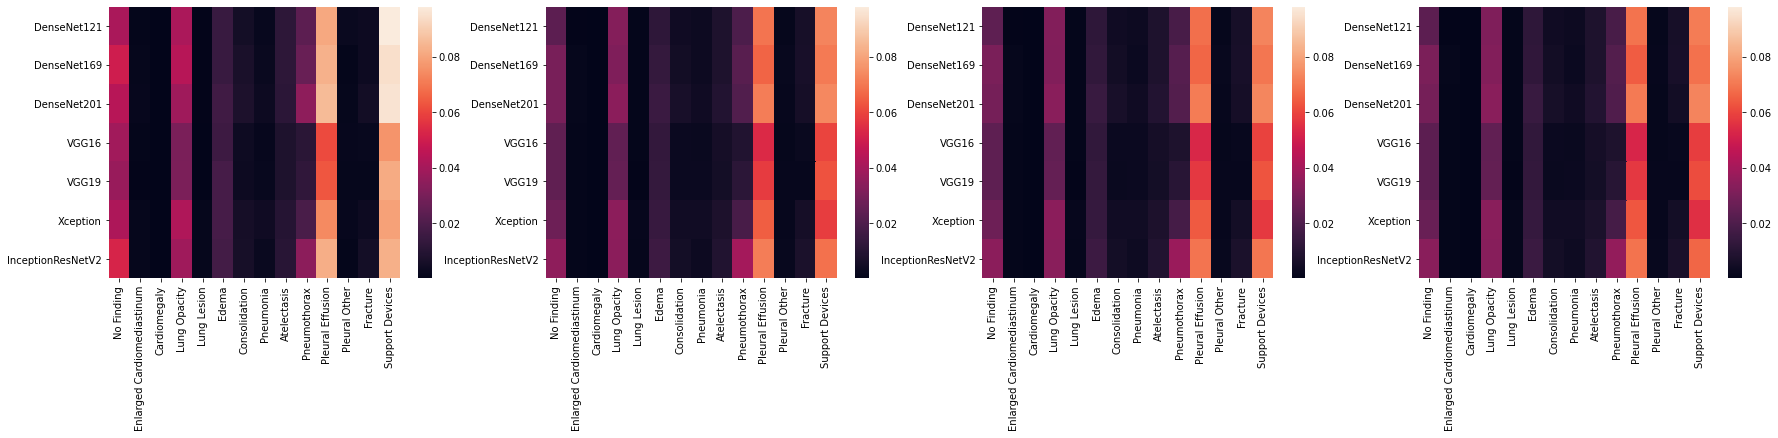

In [85]:
for model in models:

    print(x.shape)

(None, 1024)
(None, 1664)
(None, 1920)
(None, 512)
(None, 512)
(None, 2048)
(None, 1536)
